# Train a beta-TCVAE
We start by training a beta-TCVAE using `disentanglement_lib` https://github.com/google-research/disentanglement_lib
This code assumes `disentanglement_lib` has been installed (along with the datasets)

In [1]:
import os
from disentanglement_lib.methods.unsupervised import train
from keras import metrics
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import tensorflow as tf

Using TensorFlow backend.


In [2]:
base_path = "../results/dlib"
overwrite = True

### Note: The results shown here are for 10K iterations only. We trained all models for 300K iterations.

In [3]:
train.train_with_gin(os.path.join(base_path, "model"), overwrite, ['beta_tcvae_twovae_vary_beta_c10_z5_beta4.gin'])

This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


# Get (x, y) pairs as a dataset

In [4]:
from disentanglement_lib.data.ground_truth import cars3d
dta = cars3d.Cars3D()

In [5]:
dta.images.shape

(17568, 64, 64, 3)

In [6]:
import matplotlib.pyplot as plt
plt.imshow(dta.images[3948])
plt.show()

<Figure size 640x480 with 1 Axes>

In [7]:
import tensorflow_hub as hub
beta_tcvae_model_url = os.path.join(base_path, "model", "tfhub")

In [8]:
with hub.eval_function_for_module(beta_tcvae_model_url) as f:
    # Save reconstructions.
    real_pics = dta.images
    raw_pics = f(
        dict(images=real_pics), signature="reconstructions",
        as_dict=True)["images"]

W0219 23:13:56.846551 140238308050752 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


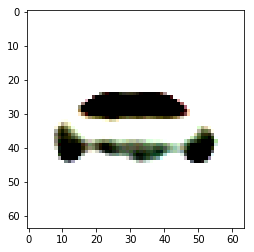

In [9]:
import matplotlib.pyplot as plt
plt.imshow(raw_pics[3948])
plt.show()

In [10]:
import sys
sys.path.insert(0, '../source_tf/utils')
sys.path.insert(0, '../source_tf/models')
from data_helpers import DataProvider
import numpy as np
import time, math
from misc import merge

In [11]:
inputs = real_pics
targets = raw_pics

In [12]:
tr_data_loader = DataProvider(inputs, targets, batch_size=32, shuffle_order=True)

In [13]:
input_shape = [64, 64, 3]

# Train DS-VAE using beta-TCVAE outputs

### Define models

In [14]:
from simgan_models import simgan_decoder, residual_encoder

In [15]:
enc_model = residual_encoder ## Inference network from (X-Y) to Z
gen_model = simgan_decoder ## Generator network (Y --> Xbar)

### Optimizers
Define optimizers and learning rates

In [16]:
gen_lr = 0.0001
disc_lr = 0.0001

In [17]:
optimizer_gen = tf.train.AdamOptimizer(gen_lr, beta1=0.9)
optimizer_disc = tf.train.AdamOptimizer(disc_lr, beta1=0.9)

### Graph

In [18]:
batchsize = 32
latent_noise_dim = 100 # size of z
tdw_img = tf.placeholder(tf.float32, [batchsize] + input_shape, name="tdw_images") #x
E_enc = tf.placeholder(tf.float32, [batchsize] + input_shape, name="dis_images") #y
latent_noise_input_ = tf.placeholder(tf.float32, [batchsize] + [latent_noise_dim], name="noise") #z

In [19]:
# Sample random images from the generator (for evaluation purposes only)
G_dec_sampler = gen_model(E_enc, latent_noise_input_, input_shape)

# Infer z using residuals
z_mu, z_sigma = enc_model(tdw_img, E_enc, latent_noise_dim)
epsilon = tf.random_normal(tf.shape(z_mu))
latent_noise_input = z_mu + (z_sigma) * epsilon

# Obtain Xbar using inferred z
G_dec = gen_model(E_enc, latent_noise_input, input_shape, reuse=True)

In [20]:
#Enc Loss
z_sigma_sq = tf.square(z_sigma)
z_log_sigma_sq = tf.log(z_sigma_sq+1e-10)
kld_loss = tf.reduce_mean(-0.5 * tf.reduce_sum(1 + z_log_sigma_sq 
                                           - tf.square(z_mu) 
                                           - tf.exp(z_log_sigma_sq), 1))
#Gen Loss
gloss = tf.reduce_mean(64*64*3*tf.reduce_mean(metrics.binary_crossentropy(tdw_img, G_dec))+kld_loss)

In [21]:
t_vars = tf.trainable_variables()
e_vars = [var for var in t_vars if 'residual_enc' in var.name]
d_vars = [var for var in t_vars if 'dec' in var.name] #simgan_decoder

vae_optim1 = optimizer_gen.minimize(gloss, var_list=d_vars+e_vars)

optim_list = [vae_optim1]
eval_list = [E_enc, G_dec, G_dec_sampler]
loss_dict = {'gloss': gloss}

### Start training

In [22]:
tic = time.time()
total_iterations = 0
nb_epoch = 1

config = tf.ConfigProto()
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())
tf.initialize_all_variables().run()
dec_saver = tf.train.Saver()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Epoch: [ 0] [  49] time: 174.0422, 


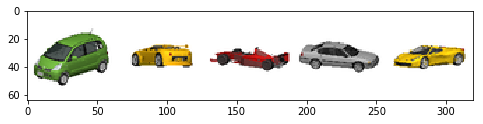

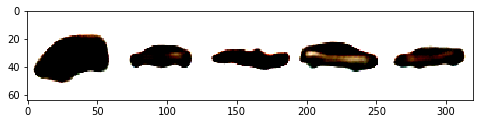

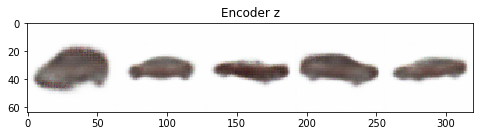

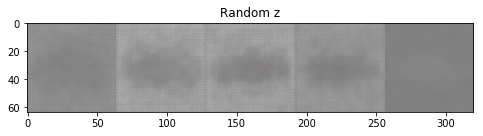

Epoch: [ 0] [ 149] time: 177.8135, 


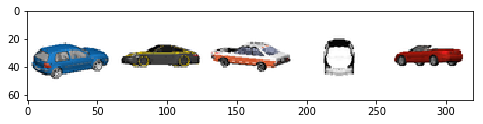

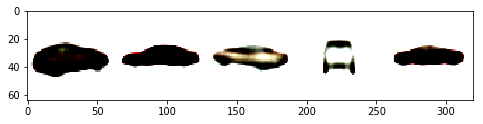

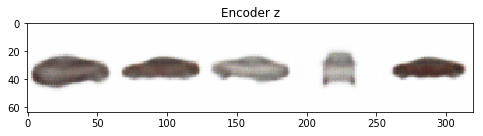

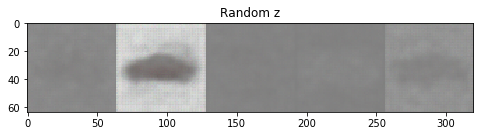

In [29]:
for n in range(nb_epoch):

    for (i, X) in enumerate(tr_data_loader):

        x = X[0]
        
        y = X[1]
        latent_noise_batch = np.random.randn(batchsize, latent_noise_dim).astype(np.float32)
        feed_dict = {tdw_img: x, latent_noise_input_: latent_noise_batch, E_enc: y}
        
        _ = sess.run(optim_list, feed_dict=feed_dict)
        
        if total_iterations%100==0:
            print("Epoch: [%2d] [%4d] time: %4.4f, " % (n, i, time.time() - tic,))

            data = sess.run(eval_list, feed_dict = feed_dict)
            
            sdata = x[:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.gray()
            plt.title('X')
            plt.show()
            
            sdata = y[:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.title('Y')
            plt.gray()
            plt.show()

            sdata = data[1][:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.gray()
            plt.title('Encoder z')
            plt.show()
            
            sdata = data[2][:5]
            sdata = np.clip(sdata,0,1)
            sdata = np.expand_dims(sdata,0)
            img = merge(sdata[0],[1,5])
            plt.figure(figsize=(8,8))
            plt.imshow(img)
            plt.gray()
            plt.title('Random z')
            plt.show()
                
        total_iterations += 1
            